In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import warnings; warnings.simplefilter('ignore')
import sys
sys.path.insert(0, '/Users/jsmonzon/Research/SatGen/mcmc/src/')
import jsm_halopull
import jsm_SHMR
import jsm_mcmc
import jsm_stats
import jsm_models

In [3]:
plt.style.use('../../../paper_1/figures/paper.mplstyle')
double_textwidth = 7.0 #inches
single_textwidth = 3.5 #inches

In [4]:
# lgMh_full = np.vstack(np.load("../../../data/MW-analog/meta_data_psi4/models.npz")["mass"])
# red_full = np.vstack(np.load("../../../data/MW-analog/meta_data_psi4/models.npz")["redshift"])
# halo_masses = np.linspace(8,12,100) # just for the model

In [5]:
lgMh_full = np.vstack(np.load("../../../data/cross_host/lognorm_015_psi3/models.npz")["mass"])
red_full = np.vstack(np.load("../../../data/cross_host/lognorm_015_psi3/models.npz")["redshift"])
halo_masses = np.linspace(8,12,100) # just for the model

In [6]:
def stat_plot(theta, colorpick, saveplot=False):

    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(double_textwidth,double_textwidth))

    theta_det = theta[:2] + [0, 0] + theta[4:]
    sigma = theta[2] + theta[3]*(halo_masses-12)

    lgMs_full = jsm_SHMR.general_old(theta, lgMh_full, red_full, 1)
    det = jsm_SHMR.general_old(theta_det, halo_masses, 0, 1)

    lgMh_example = lgMh_full[0:100]
    lgMs_example = lgMs_full[0:100]
    stat = jsm_stats.SatStats_D(lgMs_example, min_mass=6.5, max_N=300)

    ax1.fill_between(halo_masses, det - sigma, det + sigma, color=colorpick, alpha=0.15)
    ax1.fill_between(halo_masses, det - 2 * sigma, det + 2 * sigma, color=colorpick, alpha=0.1)
    ax1.fill_between(halo_masses, det - 3 * sigma, det + 3 * sigma, color=colorpick, alpha=0.1)

    above_limit = lgMs_example.flatten() > 6.5
    ax1.scatter(lgMh_example.flatten()[above_limit], lgMs_example.flatten()[above_limit], marker="*", s=15, color=colorpick)
    ax1.scatter(lgMh_example.flatten()[~above_limit], lgMs_example.flatten()[~above_limit], marker="*", s=15, color="grey")


    ax1.plot(halo_masses, jsm_SHMR.lgMs_RP17(halo_masses), color="darkmagenta", ls="--", label="RP17")
    ax1.plot(halo_masses, jsm_SHMR.lgMs_B13(halo_masses), color="darkorange", ls="--", label="B13")
    ax1.axhline(6.5, color="grey", ls=":")
    ax1.set_xlim(8.5,12)
    ax1.set_ylim(6.1,10.5)
    ax1.set_ylabel("$\log M_{*}\ [\mathrm{M}_{\odot}]$")
    ax1.set_xlabel("$\log M_{\mathrm{acc}}\ [\mathrm{M}_{\odot}]$")
    ax1.legend()

    rand = np.random.randint(0,100,4)
    for i in rand:
        high = np.column_stack([np.array([10.5]*stat.mass_rank.shape[0]), stat.mass_rank])
        low = np.column_stack([np.array([6.5]*high.shape[0]), np.sort(high)])
        ax2.step(low[i][~np.isnan(low[i])][::-1], np.append(np.arange(stat.Nsat_perhost[i]+1), stat.Nsat_perhost[i]), where="mid")
        ax6.scatter(stat.Nsat_perhost[i], stat.maxmass[i], s=100, marker="o", zorder=10, alpha=0.7)

    ax2.set_ylabel("$N (>  M_{*})$")
    ax2.set_xlabel("$\log M_{*}\ [\mathrm{M}_{\odot}]$")
    ax2.set_xlim(6.5,10.5)

    stack_bins = np.linspace(6.4, 10.7, 25)
    bin_centers = (stack_bins[:-1] + stack_bins[1:]) / 2
    count_mat = np.apply_along_axis(jsm_stats.count, 1, stat.lgMs, mass_bins=stack_bins)
    stack = np.sum(count_mat, axis=0)

    ax3.step(bin_centers, stack, color=colorpick, where="mid")
    ax3.set_ylabel("$ N_{\mathrm{stacked}}$")
    ax3.set_xlabel("$\log M_{*}\ [\mathrm{M}_{\odot}]$")
    ax3.set_yscale("log")
    ax3.set_xlim(6.5)
    # total = np.sort(stat.mass_rank.flatten())[~np.isnan(np.sort(stat.mass_rank.flatten()))]
    # ax3.step(total, np.arange(0, total.shape[0])[::-1], color=colorpick, where="mid")
    # ax3.set_ylabel("$ N_{\mathrm{total}} (>  M_{*})$")
    # ax3.set_xlabel("$\log M_{*}\ [\mathrm{M}_{\odot}]$")
    # ax3.set_yscale("log")
    # ax3.set_xlim(6.5)

    max_mass_bins = np.linspace(6.4, 10.7, 25)
    counts, bincenters = jsm_stats.count(stat.maxmass, max_mass_bins, return_bins=True)
    ax4.step(bincenters, counts, where="mid", color=colorpick)
    ax4.hist(stat.maxmass, max_mass_bins, color=colorpick, alpha=0.3, edgecolor="white")
    ax4.set_xlabel("$\log M_{*, 1}\ [\mathrm{M}_{\odot}]$")
    ax4.set_ylabel("$N_{\mathrm{host}}$")
    ax4.set_xlim(6.5,10.5)

    Nsat_bins = np.linspace(0, 30, 31)
    counts, bincenters = jsm_stats.count(stat.Nsat_perhost, Nsat_bins, return_bins=True)
    ax5.step(bincenters, counts, where="mid", color=colorpick)
    ax5.hist(stat.Nsat_perhost, bins=Nsat_bins, color=colorpick, alpha=0.3, edgecolor="white")
    ax5.set_xlabel("$n_{\mathrm{sat}}$")
    ax5.set_ylabel("$N_{\mathrm{host}}$")
    ax5.set_xlim(0,15)

    rect = patches.Rectangle((5.5, 6.7), 1, 3.7, linewidth=2, edgecolor='grey', facecolor="None", ls="--")
    ax6.scatter(stat.Nsat_perhost, stat.maxmass, color=colorpick, s=20, marker="*")
    ax6.add_patch(rect)
    ax6.text(9.8, 7, "$r_{\mathrm{P}} =$"+f"{stat.correlation:.3f}", fontsize=15,  bbox=dict(facecolor='white', alpha=1, edgecolor=colorpick))
    ax6.set_ylabel("$\log M_{*, 1}\ [\mathrm{M}_{\odot}]$")
    ax6.set_xlabel("$n_{\mathrm{sat}}$")
    ax6.set_xlim(0,18)
    ax6.set_ylim(6.5,10.5)


    ax1.text(0.9, 0.85, "A", transform=ax1.transAxes, bbox=dict(facecolor='white', alpha=1, edgecolor=colorpick))
    ax2.text(0.9, 0.85, "B", transform=ax2.transAxes, bbox=dict(facecolor='white', alpha=1, edgecolor=colorpick))
    ax3.text(0.9, 0.85, "C", transform=ax3.transAxes, bbox=dict(facecolor='white', alpha=1, edgecolor=colorpick))
    ax4.text(0.9, 0.85, "D", transform=ax4.transAxes, bbox=dict(facecolor='white', alpha=1, edgecolor=colorpick))
    ax5.text(0.9, 0.85, "E", transform=ax5.transAxes, bbox=dict(facecolor='white', alpha=1, edgecolor=colorpick))
    ax6.text(0.9, 0.85, "F", transform=ax6.transAxes, bbox=dict(facecolor='white', alpha=1, edgecolor=colorpick))

    plt.tight_layout()
    if saveplot:
        plt.savefig("../../../paper_1/figures/updated/tutorial.pdf", bbox_inches="tight")
    plt.show()

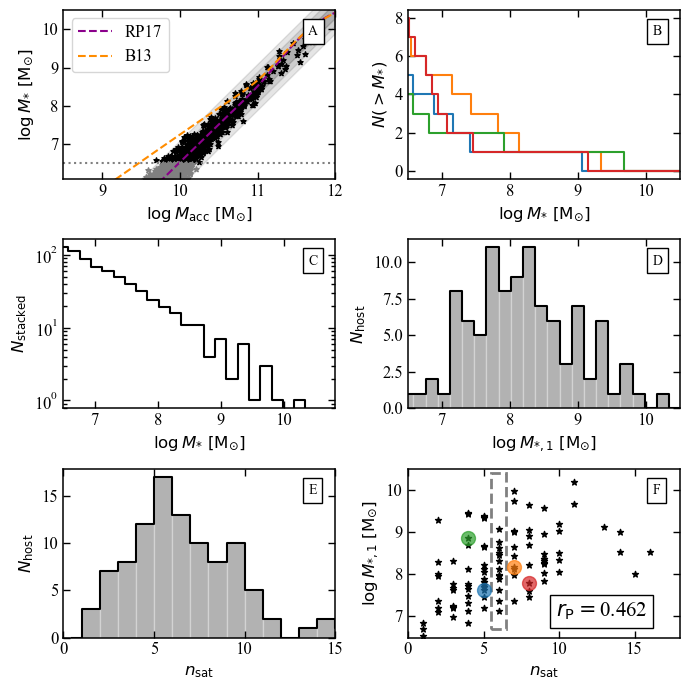

In [7]:
stat_plot([10.5, 2.0, 0.2, 0.0, 0.0, 0.0], "k", saveplot=True)

In [8]:
# lgMh_full = np.vstack(np.load("../../../data/cross_host/lognorm_015_psi3/models.npz")["mass"])
# red_full = np.vstack(np.load("../../../data/cross_host/lognorm_015_psi3/models.npz")["redshift"])
# halo_masses = np.linspace(8,12,100) # just for the model

# def stat_plot(theta, colorpick):
        
#     fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(double_textwidth,double_textwidth))


#     theta_det = [theta[0], theta[1], theta[2], theta[3], 0.0, 0.0]
#     sigma = theta[4] + theta[5]*(halo_masses-12)

#     lgMs_full = jsm_SHMR.general_new(theta, lgMh_full, red_full, 1)
#     det = jsm_SHMR.general_new(theta_det, halo_masses, 0, 1)

#     lgMh_example = lgMh_full[0:100]
#     lgMs_example = lgMs_full[0:100]
#     stat = jsm_stats.SatStats_D(lgMs_example, min_mass=6.5, max_N=400)

#     ax1.fill_between(halo_masses, det - sigma, det + sigma, color=colorpick, alpha=0.15)
#     ax1.fill_between(halo_masses, det - 2 * sigma, det + 2 * sigma, color=colorpick, alpha=0.1)
#     ax1.fill_between(halo_masses, det - 3 * sigma, det + 3 * sigma, color=colorpick, alpha=0.1)

#     above_limit = lgMs_example.flatten() > 6.5
#     ax1.scatter(lgMh_example.flatten()[above_limit], lgMs_example.flatten()[above_limit], marker="*", s=15, color=colorpick)
#     ax1.scatter(lgMh_example.flatten()[~above_limit], lgMs_example.flatten()[~above_limit], marker="*", s=15, color="grey")


#     ax1.plot(halo_masses, jsm_SHMR.lgMs_RP17(halo_masses), color="darkmagenta", ls="--", label="RP17")
#     ax1.plot(halo_masses, jsm_SHMR.lgMs_B13(halo_masses), color="darkorange", ls="--", label="B13")
#     ax1.axhline(6.5, color="grey", ls=":")
#     ax1.set_xlim(8.5,12)
#     ax1.set_ylim(6.1,10.5)
#     ax1.set_ylabel("$\log M_{*}\ [\mathrm{M}_{\odot}]$")
#     ax1.set_xlabel("$\log M_{\mathrm{acc}}\ [\mathrm{M}_{\odot}]$")
#     ax1.legend()

#     rand = np.random.randint(0,100,4)
#     for i in rand:
#         high = np.column_stack([np.array([10.5]*stat.mass_rank.shape[0]), stat.mass_rank])
#         low = np.column_stack([np.array([6.5]*high.shape[0]), np.sort(high)])
#         ax2.step(low[i][~np.isnan(low[i])][::-1], np.append(np.arange(stat.Nsat_perhost[i]+1), stat.Nsat_perhost[i]), where="mid")
#         ax6.scatter(stat.Nsat_perhost[i], stat.maxmass[i], s=100, marker="o", zorder=10, alpha=0.7)

#     ax2.set_ylabel("$N (>  M_{*})$")
#     ax2.set_xlabel("$\log M_{*}\ [\mathrm{M}_{\odot}]$")
#     ax2.set_xlim(6.5,10.5)

#     stack_bins = np.linspace(6.4, 10.7, 25)
#     bin_centers = (stack_bins[:-1] + stack_bins[1:]) / 2
#     count_mat = np.apply_along_axis(jsm_stats.count, 1, stat.lgMs, mass_bins=stack_bins)
#     stack = np.sum(count_mat, axis=0)
    
#     ax3.step(bin_centers, stack, color=colorpick, where="mid")
#     ax3.set_ylabel("$ N_{\mathrm{stacked}}$")
#     ax3.set_xlabel("$\log M_{*}\ [\mathrm{M}_{\odot}]$")
#     ax3.set_yscale("log")
#     ax3.set_xlim(6.5)

#     max_mass_bins = np.linspace(6.4, 10.7, 25)
#     counts, bincenters = jsm_stats.count(stat.maxmass, max_mass_bins, return_bins=True)
#     ax4.step(bincenters, counts, where="mid", color=colorpick)
#     ax4.hist(stat.maxmass, max_mass_bins, color=colorpick, alpha=0.3, edgecolor="white")
#     ax4.set_xlabel("$\log M_{*}^{\mathrm{max}}\ [\mathrm{M}_{\odot}]$")
#     ax4.set_ylabel("$N_{\mathrm{host}}$")
#     ax4.set_xlim(6.5,10.5)

#     Nsat_bins = np.linspace(0, 30, 31)
#     counts, bincenters = jsm_stats.count(stat.Nsat_perhost, Nsat_bins, return_bins=True)
#     ax5.step(bincenters, counts, where="mid", color=colorpick)
#     ax5.hist(stat.Nsat_perhost, bins=Nsat_bins, color=colorpick, alpha=0.3, edgecolor="white")
#     ax5.set_xlabel("$n_{\mathrm{sat}}$")
#     ax5.set_ylabel("$N_{\mathrm{host}}$")
#     ax5.set_xlim(0,15)

#     rect = patches.Rectangle((5.5, 6.7), 1, 3.7, linewidth=2, edgecolor='grey', facecolor="None", ls="--")
#     ax6.scatter(stat.Nsat_perhost, stat.maxmass, color=colorpick, s=20, marker="*")
#     ax6.add_patch(rect)
#     ax6.text(9.8, 7, "$r_{\mathrm{P}} =$"+f"{stat.correlation:.3f}", fontsize=15,  bbox=dict(facecolor='white', alpha=1, edgecolor=colorpick))
#     ax6.set_ylabel("$\log M_{*}^{\mathrm{max}}\ [\mathrm{M}_{\odot}]$")
#     ax6.set_xlabel("$n_{\mathrm{sat}}$")
#     ax6.set_xlim(0,18)
#     ax6.set_ylim(6.5,10.5)


#     ax1.text(0.9, 0.85, "A", transform=ax1.transAxes, fontsize=15, fontweight='bold', bbox=dict(facecolor='white', alpha=1, edgecolor=colorpick))
#     ax2.text(0.9, 0.85, "B", transform=ax2.transAxes, fontsize=15, fontweight='bold', bbox=dict(facecolor='white', alpha=1, edgecolor=colorpick))
#     ax3.text(0.9, 0.85, "C", transform=ax3.transAxes, fontsize=15, fontweight='bold', bbox=dict(facecolor='white', alpha=1, edgecolor=colorpick))
#     ax4.text(0.9, 0.85, "D", transform=ax4.transAxes, fontsize=15, fontweight='bold', bbox=dict(facecolor='white', alpha=1, edgecolor=colorpick))
#     ax5.text(0.9, 0.85, "E", transform=ax5.transAxes, fontsize=15, fontweight='bold', bbox=dict(facecolor='white', alpha=1, edgecolor=colorpick))
#     ax6.text(0.9, 0.85, "F", transform=ax6.transAxes, fontsize=15, fontweight='bold', bbox=dict(facecolor='white', alpha=1, edgecolor=colorpick))

#     plt.tight_layout()
#     plt.show()